in this notebook, for a given runlist, the error estimation is done

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from gammapy.data import DataStore

import warnings
warnings.filterwarnings('ignore')

# ADD HERE YOUR INTEREST

If you are following this repository and you already have a source folder, check that source_flag is True and add the source name.

Else, check that source_flag is False, and add the runslist for what you want to calculate the error and add the output path for it.

NOTE: the outputfile will give you the systematic error from 0.1-100TeV divided into 24 bins in units of statistical std.
if you want it in units of bkg percentage, multiply this result by 1/sqrt(bkg_i), 
where bkg_i is the number of bkg events in the entire off region (whole FoV excluded the gamma sources)

In [2]:
source_flag= True
edisp = False
muoneff_flag=True

if source_flag:
    source='Crab' # Crab
    obsid_list = np.loadtxt(f'{source}/runlist.txt').astype(int)
    output_path=source
else:
    obsid_list = np.loadtxt(f'{source}/runlist.txt').astype(int)
    output_path= None
    
#else:
#    obsid_list = np.loadtxt(f'/home/vault/caph/mppi062h/repositories/syserror_3d_bkgmodel/2-source_dataset/GC_0.19/final_runlist_20220517_dataset002_hess1_and_2.txt').astype(int)
#    output_path= '/home/vault/caph/mppi062h/repositories/syserror_3d_bkgmodel/2-source_dataset/GC_0.19/'

In [3]:
#obsid_list = np.loadtxt(f'/home/vault/caph/mppi062h/repositories/syserror_3d_bkgmodel/2-source_dataset/GC_0.19/final_runlist_20220517_dataset002_hess1_and_2.txt').astype(int)
#output_path= '/home/vault/caph/mppi062h/repositories/syserror_3d_bkgmodel/2-source_dataset/GC_0.19/'

In [4]:
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']

hesseras = ['hess1', 'hess2']
model_str = ['B', 'D', 'C']
energy_bins = np.logspace(-1, 2, N_ebins+1)

if N_ebins==24:
    e_center= [0.1154782 ,  0.15399265,  0.2053525 ,  0.27384197,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478201,  1.53992656,
            2.05352501,  2.73841962,  3.65174137,  4.86967527,  6.49381614,
            8.65964312, 11.54781997, 15.3992658 , 20.53525094, 27.38419634,
           36.51741269, 48.6967522 , 64.93816094, 86.59643066]

the important parameter here is 'total_std' and 'total_per'. The first one relates to the systematic in std units and the second one to percentage of bkg.

The hierarchy is as the following
- hessera
- number of energy bin
- zenith bin
- model bin (for muoneff)
- number of runs from the choosen dataset in this configuration, systematic error in this configuration

In [5]:
# getting the zenith pointing of them

error_list = []

total_std = []
total_per = []

len_hesseras=2 # because usually i am estimating the error for hess1 and hess2
for hessera in hesseras:
    total_hessera_std = np.zeros((N_ebins, 7, 3, 2))
    total_hessera_per = np.zeros((N_ebins, 7, 3, 2))
    
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    table = ds.obs_table
    mask = [True if obsid in obsid_list else False for obsid in table['OBS_ID']]
    
    if np.sum(mask) == 0:
        print(f'no runs for {hessera}')
        len_hesseras = 1
    else:
        table=table[mask]

        ### opening the error estimation
        er_est = np.ndarray((7, 3, 2, 24))            
        if muoneff_flag==False:
            model=2
            er_est[:, model, 0] = np.loadtxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}.txt')
            er_est[:, model, 1] = np.loadtxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}_bkgpercentage.txt')    
        elif hessera=='hess2':
            model=2
            er_est[:, model, 0] = np.loadtxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}.txt')
            er_est[:, model, 1] = np.loadtxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}_bkgpercentage.txt')    
        else:
            for model in range(3):
                er_est[:, model, 0] = np.loadtxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}.txt')
                er_est[:, model, 1] = np.loadtxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}_bkgpercentage.txt')    
        
        setting=np.ndarray((len(table), 2)) # the first parameter is for zen bin and second for muoneff

        for zen_idx in range(7):
            mask_zen1 = table['ZEN_PNT'] > zen_bins[zen_idx]
            mask_zen2 = table['ZEN_PNT'] < zen_bins[zen_idx+1]
            mask_zen = mask_zen1 & mask_zen2
            setting[mask_zen, 0] = zen_idx

        mask_muoneff1 = table['MUONEFF'] > 0.085
        setting[mask_muoneff1, 1] = 0
        mask_muoneff2 = table['MUONEFF'] < 0.075
        setting[mask_muoneff2, 1] = 2
        mask_muoneff3 = mask_muoneff1 + mask_muoneff2
        setting[~mask_muoneff3, 1] = 1
        
        error_hessera = np.zeros((N_ebins))
        for e_idx in range(N_ebins):
            error2_aux = 0

            for zen in range(7):
                for model in range(3):
                    m1= setting[:, 0] == zen
                    m2 = setting[:, 1] == model
                    m = m1 & m2
                    if (er_est[zen][model][0][e_idx] ==0) or np.isnan(er_est[zen][model][0][e_idx]):
                        N_runs =int(0)
                    else:
                        N_runs=np.sum(m)
                    total_hessera_std[e_idx, zen, model] = N_runs, er_est[zen][model][0][e_idx]
                    total_hessera_per[e_idx, zen, model] = N_runs, er_est[zen][model][1][e_idx]
                    
        total_std.append(total_hessera_std)
        total_per.append(total_hessera_per)        

# plots to help to understand how to add the bias

### plots1: each model contribution - like it is in the estimation

This first set of plots shows the contribution of the systematic bias per each model bin (zen, different columns, and model, different colors) in function of energy.
The label shows how many runs for the choosen dataset is present in each model bin.

first plots in units of std, and second plots in units of % of bkg

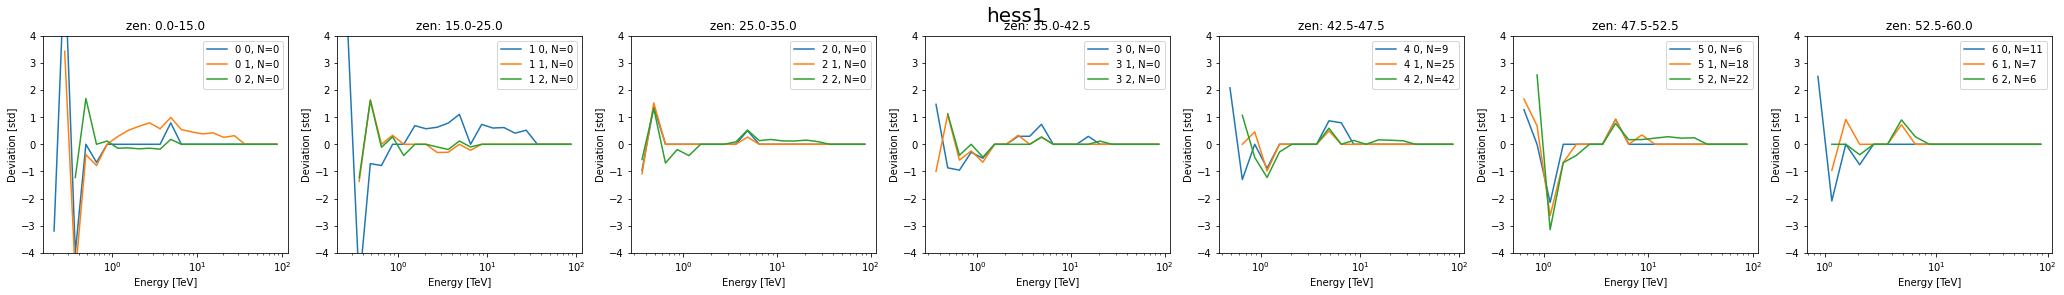

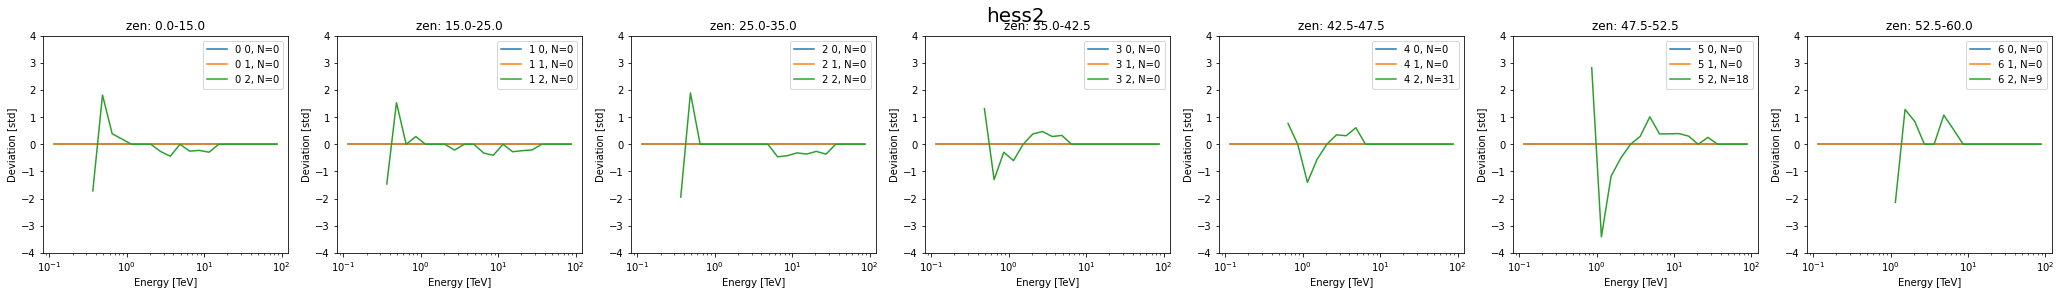

In [6]:
for hessera_idx in range(len_hesseras):

    fig, ax = plt.subplots(1, 7, figsize=(3*12,4))
    for zen in range(7):
        for model in range(3):
            N_runs = total_std[hessera_idx][:, zen, model][:, 0]
            if np.all(N_runs==0):
                N_runs=0
            else:
                N_runs = N_runs[N_runs!=0][0]                
            ax[zen].plot(e_center, total_std[hessera_idx][:, zen, model][:, 1], color=f'C{model}', label=f'{zen} {model}, N={int(N_runs)}')
        ax[zen].legend(loc='upper right')
        ax[zen].set_xscale('log')
        ax[zen].set_ylim(-4, 4)
        ax[zen].set_ylabel('Deviation [std]')
        ax[zen].set_xlabel('Energy [TeV]')
        ax[zen].set_title(f'zen: {zen_bins[zen]}-{zen_bins[zen+1]}')
    plt.suptitle(hesseras[hessera_idx], size=20)
    plt.show()


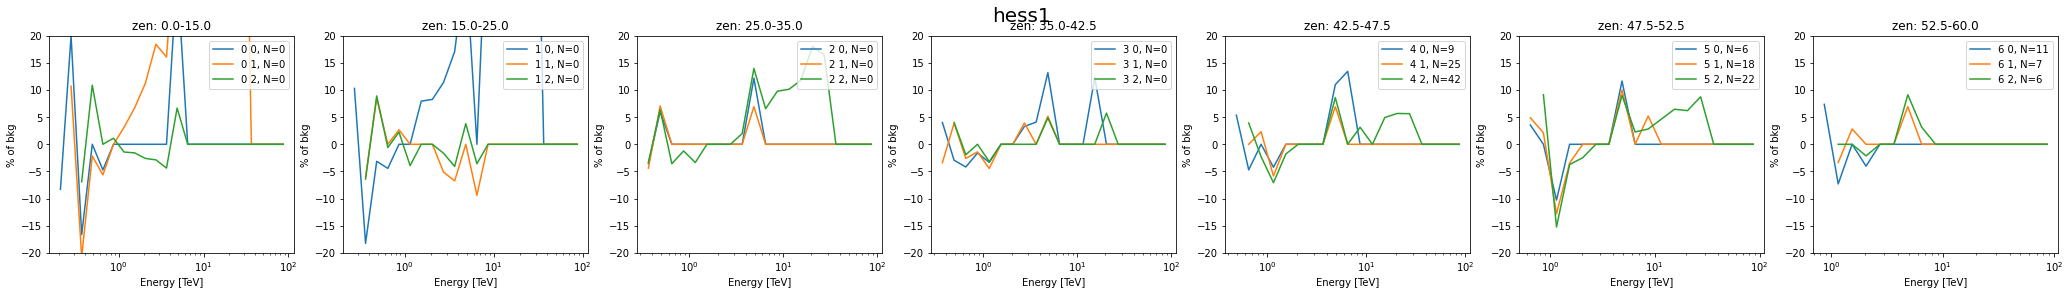

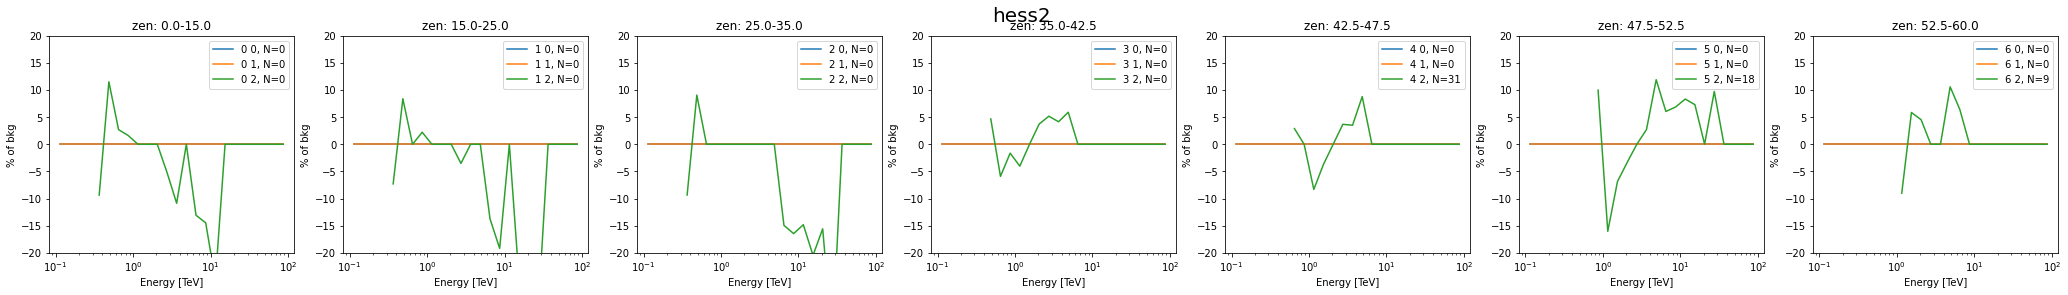

In [7]:
for hessera_idx in range(len_hesseras):
    fig, ax = plt.subplots(1, 7, figsize=(3*12,4))
    for zen in range(7):
        for model in range(3):
            N_runs = total_std[hessera_idx][:, zen, model][:, 0]
            if np.all(N_runs==0):
                N_runs=0
            else:
                N_runs = N_runs[N_runs!=0][0]                
            ax[zen].plot(e_center, total_per[hessera_idx][:, zen, model][:, 1], color=f'C{model}', label=f'{zen} {model}, N={int(N_runs)}')
    
        ax[zen].legend(loc='upper right')
        ax[zen].set_xscale('log')
        ax[zen].set_ylabel('% of bkg')
        ax[zen].set_ylim(-20, 20)
        ax[zen].set_xlabel('Energy [TeV]')
        ax[zen].set_title(f'zen: {zen_bins[zen]}-{zen_bins[zen+1]}')
    plt.suptitle(hesseras[hessera_idx], size=20)
    plt.show()


# adding the error for the full dataset

first of all we need to know how many runs contribute with systematic error in each energy bin. 
For instance for runs with low zenith will contribute with systematic bias to energy bins at lower energies, while the runs in the high zenith will not contribute to such low energies.

Thus it is important to know how many runs contribute in each energy bin

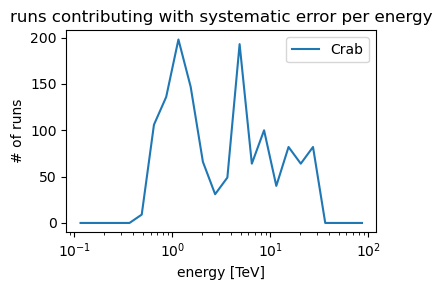

In [8]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

N_runs_total = np.zeros(24, dtype=int)
for hessera_idx in range(len_hesseras):
    for zen in range(7):
        for model in range(3):
            N_runs_total += total_std[hessera_idx][:, zen, model][:, 0].astype(int)

ax.plot(e_center, N_runs_total, label=source)
ax.set_xscale('log')
ax.set_xlabel('energy [TeV]')
ax.set_ylabel('# of runs')
ax.legend()
ax.set_title('runs contributing with systematic error per energy')
plt.tight_layout()
plt.savefig('/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/0-plots_for_confluencepage/10.png')

Then, we need to know how many runs from the total contribute in each model bin.

Since we are summing the % of bkg, it is important to sum the contribution of the bias taking into a account the weight of each bin (which means, how many runs in each model bin contribute, related to the total number of runs in this energy bin)

The plot below shows the contribution of each model bin with the correct weight of each run

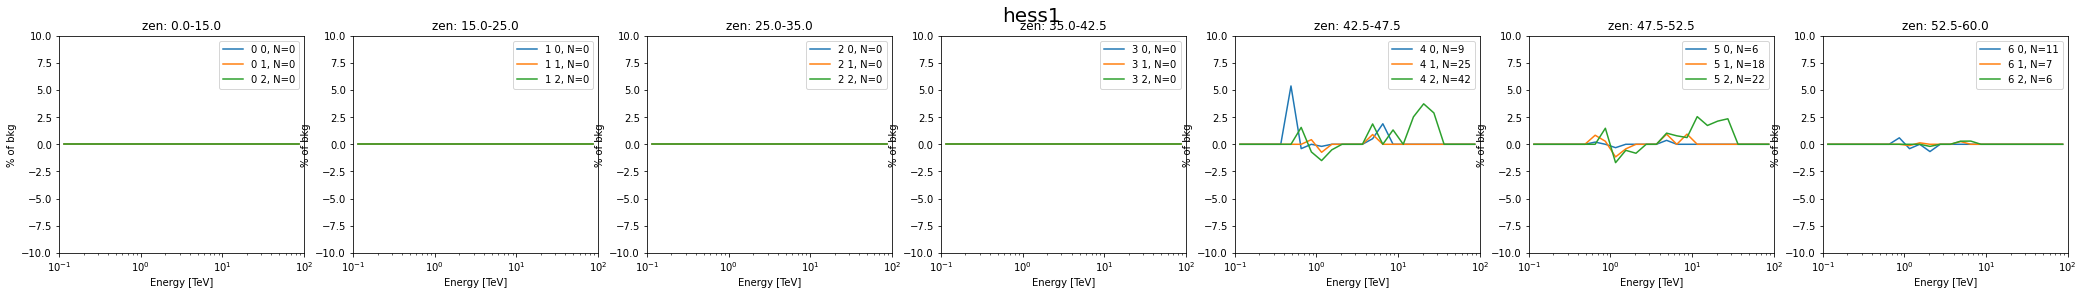

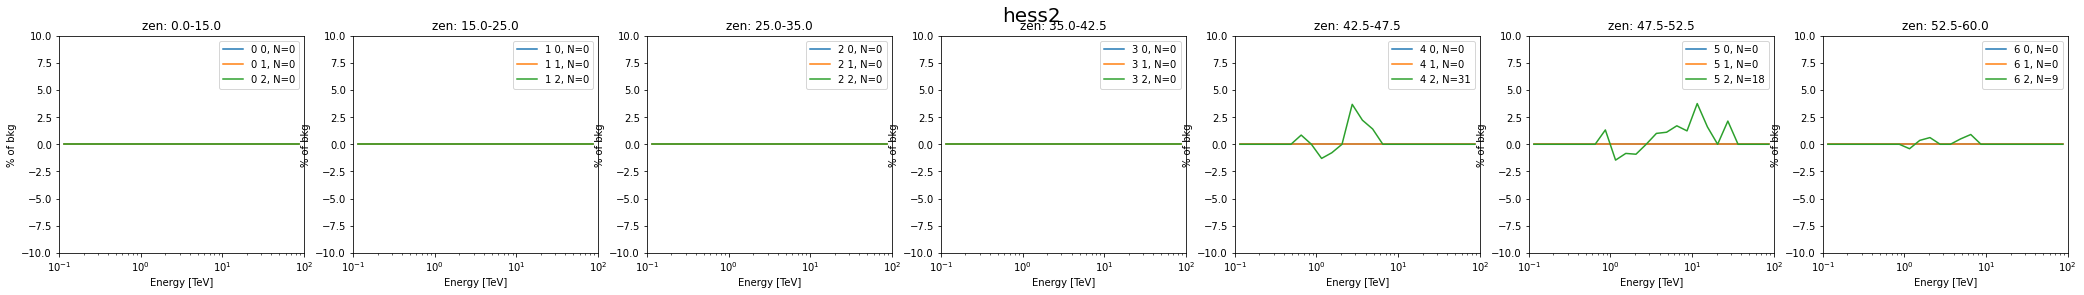

In [9]:
N_runs_total = np.zeros(24, dtype=int)
for hessera_idx in range(len_hesseras):
    for zen in range(7):
        for model in range(3):
            N_runs_total += total_std[hessera_idx][:, zen, model][:, 0].astype(int)

for hessera_idx in range(len_hesseras):
            
    fig, ax = plt.subplots(1, 7, figsize=(3*12,4))
    for zen in range(7):
        for model in range(3):
            N_runs = total_std[hessera_idx][:, zen, model][:, 0]            
            to_plot=(N_runs/N_runs_total)*total_per[hessera_idx][:, zen, model][:, 1]
            if np.all(N_runs==0):
                N_runs_leg=0
            else:
                N_runs_leg = N_runs[N_runs!=0][0]                
            
            to_plot[np.isnan(to_plot)] = 0
            ax[zen].plot(e_center, to_plot , color=f'C{model}', label=f'{zen} {model}, N={int(N_runs_leg)}')
        ax[zen].legend(loc='upper right')
        ax[zen].set_xscale('log')
        ax[zen].set_xlim(1e-1, 1e2)
        ax[zen].set_ylim(-10, 10)
        ax[zen].set_ylabel('% of bkg')
        ax[zen].set_xlabel('Energy [TeV]')
        ax[zen].set_title(f'zen: {zen_bins[zen]}-{zen_bins[zen+1]}')
    plt.suptitle(hesseras[hessera_idx], size=20)
    plt.show()


### all contribution in one plot

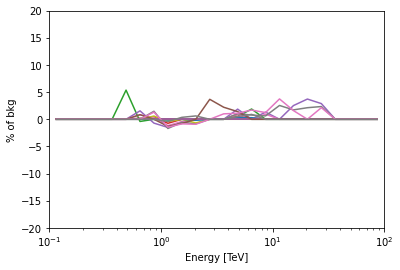

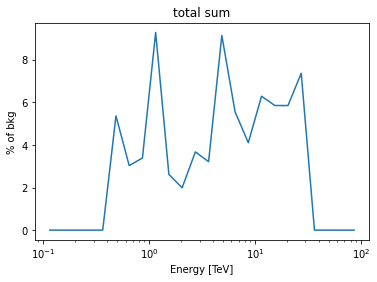

In [14]:
e_sum= []

N_runs_total = np.zeros(24, dtype=int)
for hessera_idx in range(len_hesseras):
    for zen in range(7):
        for model in range(3):
            N_runs_total += total_std[hessera_idx][:, zen, model][:, 0].astype(int)
            
for hessera_idx in range(len_hesseras):
    for zen in range(7):
        if hessera_idx == 0:
            starting =0
        else:
            starting=2
        for model in range(starting, 3):
            N_runs = total_std[hessera_idx][:, zen, model][:, 0].astype(int)
            to_plot=(N_runs/N_runs_total)*total_per[hessera_idx][:, zen, model][:, 1]
            to_plot[np.isnan(to_plot)] = 0
            plt.plot(e_center, to_plot, label=f'{hessera_idx} {zen} {model}')
            e_sum.append(to_plot)
plt.xscale('log')
plt.ylabel('% of bkg')
plt.xlabel('Energy [TeV]')
plt.ylim(-20,20)
plt.xlim(1e-1,1e2)

plt.show()

e_sum_final =abs(np.nansum(e_sum, axis=0))
e_sum_final[np.isinf(e_sum_final)] =0

plt.plot(e_center, e_sum_final)
plt.xscale('log')
plt.ylabel('% of bkg')
plt.xlabel('Energy [TeV]')
plt.title('total sum')
#plt.ylim(-5,30)
plt.show()

In [15]:
np.savetxt(f'{source}/sysamplitude_percentage.txt', np.nansum(e_sum, axis=0))

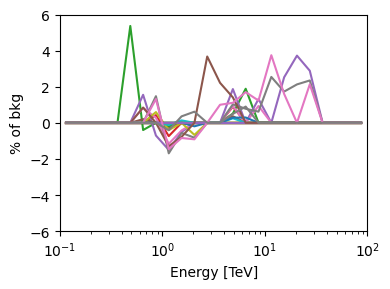

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

for hessera_idx in range(len_hesseras):
    for zen in range(7):
        if hessera_idx == 0:
            starting =0
        else:
            starting=2
        for model in range(starting, 3):
            N_runs = total_std[hessera_idx][:, zen, model][:, 0].astype(int)
            to_plot=(N_runs/N_runs_total)*total_per[hessera_idx][:, zen, model][:, 1]
            to_plot[np.isnan(to_plot)] = 0
            ax.plot(e_center, to_plot, label=f'{hessera_idx} {zen} {model}')
            e_sum.append(to_plot)
ax.set_xscale('log')
ax.set_ylabel('% of bkg')
ax.set_xlabel('Energy [TeV]')
ax.set_ylim(-6,6)
ax.set_xlim(1e-1,1e2)
plt.tight_layout()
plt.savefig('/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/0-plots_for_confluencepage/11.png')

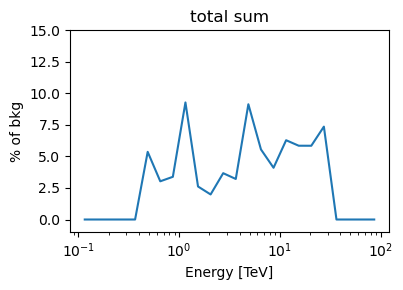

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

ax.plot(e_center, e_sum_final)
ax.set_xscale('log')
ax.set_ylabel('% of bkg')
ax.set_xlabel('Energy [TeV]')
ax.set_title('total sum')
plt.ylim(-1, 15)
plt.tight_layout()
plt.savefig('/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/0-plots_for_confluencepage/12.png')

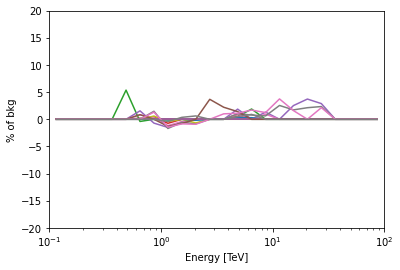

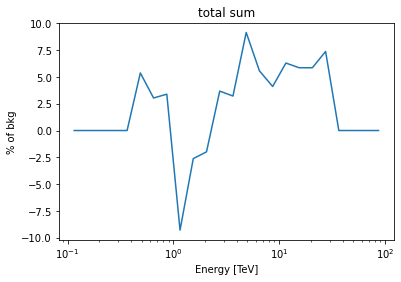

In [20]:
e_sum= []

N_runs_total = np.zeros(24, dtype=int)
for hessera_idx in range(len_hesseras):
    for zen in range(7):
        for model in range(3):
            N_runs_total += total_std[hessera_idx][:, zen, model][:, 0].astype(int)
            
for hessera_idx in range(len_hesseras):
    for zen in range(7):
        if hessera_idx == 0:
            starting =0
        else:
            starting=2
        for model in range(starting, 3):
            N_runs = total_std[hessera_idx][:, zen, model][:, 0].astype(int)
            to_plot=(N_runs/N_runs_total)*total_per[hessera_idx][:, zen, model][:, 1]
            to_plot[np.isnan(to_plot)] = 0
            plt.plot(e_center, to_plot, label=f'{hessera_idx} {zen} {model}')
            e_sum.append(to_plot)
plt.xscale('log')
plt.ylabel('% of bkg')
plt.xlabel('Energy [TeV]')
plt.ylim(-20,20)
plt.xlim(1e-1,1e2)

plt.show()

e_sum_final =np.nansum(e_sum, axis=0)
e_sum_final[np.isinf(e_sum_final)] =0

plt.plot(e_center, e_sum_final)
plt.xscale('log')
plt.ylabel('% of bkg')
plt.xlabel('Energy [TeV]')
plt.title('total sum')
#plt.ylim(-5,30)
plt.show()

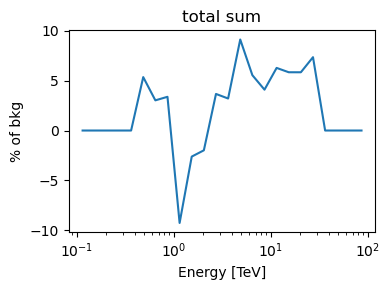

In [22]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

ax.plot(e_center, e_sum_final)
ax.set_xscale('log')
ax.set_ylabel('% of bkg')
ax.set_xlabel('Energy [TeV]')
ax.set_title('total sum')
plt.tight_layout()
plt.savefig('/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/0-plots_for_confluencepage/12.png')